In [159]:
import numpy as np
import pandas as pd
import gurobipy as gp
import math

In [160]:
df_19=pd.read_csv('stocks2019.csv')
df_20=pd.read_csv('stocks2020.csv')

In [161]:
column_names = df_19.columns[1:]

i = 0
j = 0
returns_total = []
returns = []
returns_total20 = []
returns2 = []
while i < len(column_names):
    returns = []
    j = 0
    while j < len(df_19):
        if j == 0:
            returns.append(0)
            j += 1
        else:
            returns.append((df_19[column_names[i]][j] - df_19[column_names[i]][j - 1])/df_19[column_names[i]][j - 1])
            j += 1
    returns_total.append(returns)
    i += 1

i = 0
j = 0
while i < len(column_names):
    returns2 = []
    j = 0
    while j < len(df_20):
        if j == 0:
            returns2.append(0)
            j += 1
        else:
            returns2.append((df_20[column_names[i]][j] - df_20[column_names[i]][j - 1])/df_20[column_names[i]][j - 1])
            j += 1
    returns_total20.append(returns2)
    i += 1

In [162]:
df_19_returns = pd.DataFrame()
df_20_returns = pd.DataFrame()

i = 0
while i < len(column_names):
    df_19_returns[column_names[i]] = returns_total[i]
    df_20_returns[column_names[i]] = returns_total20[i]
    i += 1

In [163]:
df_19_clean = df_19_returns.copy()
df_20_clean = df_20_returns.copy()
NDX = list(df_19_clean['NDX'])
NDX20 = list(df_20_clean['NDX'])
df_19_clean = df_19_clean.loc[1:]
df_20_clean = df_20_clean.loc[1:]
NDX = NDX[1:]

# Part 1, Select Stock

In [164]:
df_19_clean = df_19_clean.drop(columns = 'NDX')
df_20_clean = df_20_clean.drop(columns = 'NDX')

In [165]:
cor19=np.corrcoef(df_19_clean, rowvar=False) 
cor20=np.corrcoef(df_20_clean, rowvar=False)

In [166]:
df_cor_19 = pd.DataFrame(cor19)
df_cor_20 = pd.DataFrame(cor20)

In [167]:
m = 5
n = len(cor19)

In [168]:
A = np.zeros((n*n + n + 1, n * n + n))

In [169]:
sense = ['']* (A.shape[0])
b = np.zeros(A.shape[0]) 

In [170]:
#For all X in the index, only maps to one of the stock in Fund. 
#So, for each X, there is one and only one i that Xij can map to Yj. 100 * 100 = 10000 constraints.
for i in range(n):
    for j in range(n):
        A[i,n*i + j] = 1
    sense[i] = '='
    b[i] = 1

In [171]:
#For all Xij, Xij < Yj, since 100 Y, 100 constraints.
for i in range(n):
    for j in range(n):
        A[i*n + j + n, i*n + j] = 1
        A[i*n + j + n, j + n**2] = -1
        sense[i*n + j + n] = '<'
        b[i*n + j + n] = 0

In [172]:
#Y sum up to be m.
for j in range(n):
    A[n**2 + n, n**2 + j ] = 1
sense[n**2 + n] = '='
b[n**2 + n] = m

In [173]:
obj = np.hstack((np.ndarray.flatten(cor19),np.array([0]*n)))
obj

array([1.        , 0.39993857, 0.36537639, ..., 0.        , 0.        ,
       0.        ])

In [174]:
var_type = np.array(['B']*(n*n + n))

In [175]:
npvMod = gp.Model()
npvMod_x = npvMod.addMVar(len(obj),vtype=var_type) # 'C' or 'I' or 'B'
npvMod_con = npvMod.addMConstrs(A, npvMod_x, list(sense), b)
npvMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

npvMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
npvMod.optimize()

In [176]:
npvMod.objVal

54.83990652229107

In [177]:
selected = []
q = 0
for i in npvMod_x.x[n*n:]:
    if i == 1:
        selected.append(q)
        q += 1
        
    else:
        q += 1

In [178]:
column_names = column_names[1:]

In [179]:
[column_names[i] for i in selected] #Selected stocks

['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']

# Part 2, Assign Weight and Compare

In [180]:
#250 return data per stock
N = df_19_clean.shape[0]

In [181]:
df_19_ar = np.array(df_19_clean)

In [182]:
m = 5
A=np.zeros((N * 2 + 1 , N + m)) #250 + 250 + 1 constrains, for Y > |X - 1|, and X sum up to 1.
sense=np.array(['']*A.shape[0])
b=np.zeros((A.shape[0])) 

In [183]:
for i in range(N):
    for j in range(m):
        #0:5, weight of the chosen stocks
        A[i * 2, j] = df_19_ar[i, selected[j]]
        A[i * 2 + 1, j] = df_19_ar[i, selected[j]]
    # Y > X - R
    A[i * 2, i + m] = -1
    sense[i * 2] = '<'
    b[i * 2] = NDX[i]
    # Y > R - X
    A[i * 2 + 1, i + m] = 1
    sense[i * 2 + 1] = '>'
    b[i * 2 + 1] = NDX[i]

#Sum of weight = 1
for i in range(m):
    A[N*2, i] = 1
    
b[N*2] = 1
sense[N*2] = '='

# Objective to minimize

obj = np.hstack((np.zeros((m)),np.array([1]*N)))

In [184]:
npvMod = gp.Model()
npvMod_x = npvMod.addMVar(len(obj))
npvMod_con = npvMod.addMConstrs(A, npvMod_x, sense, b)
npvMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

npvMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
npvMod.Params.TimeLimit = 100
npvMod.optimize()
    
npvMod.objVal

0.7891782824631451

In [185]:
df_5_result = pd.DataFrame()
df_5_result['Stock'] = [column_names[i] for i in selected]
df_5_result['Weights'] = npvMod_x.x[:m]

In [186]:
df_20_returns_1 = df_20_returns.copy()
df_20_returns_1 = df_20_returns_1.drop(columns = 'NDX')
df_20_returns_1 = df_20_returns_1.loc[1:]
NDX20_1 = NDX20[1:]

In [187]:
q = 0
df_20_returns_weights_1 = df_20_returns_1.copy()

for i in df_20_returns_weights_1.columns:
    if i == df_5_result.loc[q]['Stock']:
        df_20_returns_weights_1[i] = df_20_returns_weights_1[i] * df_5_result.loc[q]['Weights']
        if q <4 :
            q += 1
    
    else:
        df_20_returns_weights_1[i] = df_20_returns_weights_1[i] * 0
    
j = 1
h = 0
while j - 1 < len(df_20_returns_weights_1):
    h += abs(sum(df_20_returns_weights_1.loc[j]) - NDX20_1[j - 1])
    j += 1

In [188]:
df_5_result

,Stock,Weights
0,LBTYK,0.048862
1,MXIM,0.210388
2,MSFT,0.580352
3,VRTX,0.071190
4,XEL,0.089208


In [189]:
print('The performance of 2019, m = 5 is: ')
npvMod.objVal

The performance of 2019, m = 5 is: 


0.7891782824631451

In [190]:
print('The performance of 2020, m = 5 is: ')
h

The performance of 2020, m = 5 is: 


1.112437345507646

# Part 3, Put into Loop for m = 10, m = 20... m = 100

In [191]:
total_selected = []
total_weights = []
result_19 = []

In [192]:
#For all Xi, Xi - Yi <= 0.
m_lst = []

Z = df_19_clean.shape[1]
u = 1

while Z >= 10:
    if u < 11:
        m_lst.append(10*u)
        u += 1
        Z -= 10
        
    else:
        Z -= 10

for m in m_lst:
    selected = []
    m = m
    n = len(cor19)
    A = np.zeros((n*n + n + 1 , n*n + n))
    sense = ['']*(n*n+n+1)
    b = np.zeros(n*n+n+1) 
    
    #For all X in the index, only maps to one of the stock in Fund. 
    #So, for each X, there is one and only one i that Xij can map to Yj. 100 * 100 = 10000 constraints.
    for i in range(n):
        for j in range(n):
            A[i,n*i + j] = 1
            
        sense[i] = '='
        b[i] = 1
        
    #For all Xij, Xij < Yj, since 100 Y, 100 constraints.
    for i in range(n):
        for j in range(n):
            A[i*n + j + n, i*n + j] = 1
            A[i*n + j + n, j + n**2] = -1
            
            sense[i*n + j + n] = '<'
            b[i*n + j + n] = 0
            
    #Y sum up to be m.
    for j in range(n):
        A[n**2 + n, n**2 + j ] = 1
        
    sense[n**2 + n] = '='
    b[n**2 + n] = m
    
    obj = np.hstack((np.ndarray.flatten(cor19),np.array([0]*n)))
    
    var_type = np.array(['B']*(n*n+n))
    
    npvMod = gp.Model()
    npvMod_x = npvMod.addMVar(len(obj),vtype=var_type) # 'C' or 'I' or 'B'
    npvMod_con = npvMod.addMConstrs(A, npvMod_x, list(sense), b)
    npvMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    npvMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    npvMod.optimize()
    
    q = 0
    for i in npvMod_x.x[n*n:]:
        if i == 1:
            selected.append(q)
            q += 1
        
        else:
            q += 1
    
    total_selected.append(selected)

In [193]:
g = 0
for m in m_lst:
    m = m
    A=np.zeros((N * 2 + 1 , N + m)) #250 + 250 + 1 constrains, for Y > |X - 1|, and X sum up to 1.
    sense=np.array(['']*A.shape[0])
    b=np.zeros((A.shape[0]))
    
    for i in range(N):
        for j in range(m):
        #weight of the chosen stocks
            A[i * 2, j] = df_19_ar[i, total_selected[g][j]]
            A[i * 2 + 1, j] = df_19_ar[i, total_selected[g][j]]
        # Y > X - R
        A[i * 2, i + m] = -1
        sense[i * 2] = '<'
        b[i * 2] = NDX[i]
        # Y > R - X
        A[i * 2 + 1, i + m] = 1
        sense[i * 2 + 1] = '>'
        b[i * 2 + 1] = NDX[i]

    #Sum of weight = 1
    for i in range(m):
        A[N*2, i] = 1
    
    b[N*2] = 1
    sense[N*2] = '='

    # Objective to minimize

    obj = np.hstack((np.zeros((m)),np.array([1]*N)))
    
    npvMod = gp.Model()
    npvMod_x = npvMod.addMVar(len(obj))
    npvMod_con = npvMod.addMConstrs(A, npvMod_x, sense, b)
    npvMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    npvMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    npvMod.Params.TimeLimit = 10
    npvMod.optimize()
    
    g += 1
    
    result_19.append(npvMod.objVal)
    total_weights.append(list(npvMod_x.x[:m]))

In [194]:
total_diff_20 = []
NDX20 = NDX20[1:]

In [195]:
df_20_weight = df_20_clean.copy()

In [196]:
df_20_weight_k = df_20_weight.copy()
total_sum = []


o = 0

while o < len(total_weights):
    df_20_weight_k = df_20_weight.copy()

    for i in df_20_weight_k.columns:
        if i not in [column_names[q] for q in total_selected[o]]:
            df_20_weight_k = df_20_weight_k.drop(columns = i)

    g = 0
    for q in df_20_weight_k.columns:
        df_20_weight_k[q] = df_20_weight_k[q] * total_weights[o][g]
        g += 1

    z = 0
    s = 0
    j = 1
    #sum of one row
    while j < len(df_20_weight_k):
        s += abs(sum(df_20_weight_k.loc[j]) - NDX20[j - 1])
        j += 1
        
    total_sum.append(s)
    o += 1

In [197]:
df_compare = pd.DataFrame()

dfidx = []

for y in m_lst:
    dfidx.append('m = ' + str(y))

In [198]:
df_compare['2019 Result'] = result_19
df_compare['2020 Result'] = total_sum
df_compare.index = dfidx
df_compare

,2019 Result,2020 Result
m = 10,0.701218,1.100511
m = 20,0.466233,0.853540
m = 30,0.407021,0.755453
m = 40,0.363281,0.767318
m = 50,0.334010,0.772208
m = 60,0.343167,1.164219
m = 70,0.169113,0.538227
m = 80,0.148219,0.543650
m = 90,0.053779,0.364608
m = 100,0.044911,0.365480


<AxesSubplot:>

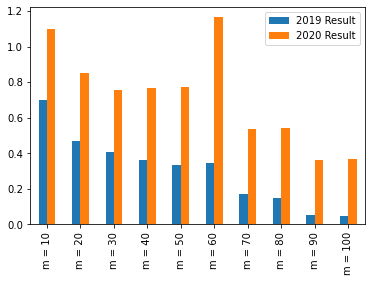

In [199]:
df_compare.plot(kind = 'bar')

# Using Method 2

In [200]:
import numpy as np
import gurobipy as gp
import pandas as pd
import math

def get_abs(x):
    return abs(x)

df_19 = pd.read_csv('stocks2019.csv')
df_20 = pd.read_csv('stocks2020.csv')

column_names = df_19.columns[1:]

i = 0
j = 0
returns_total = []
returns = []
while i < len(column_names):
    returns = []
    j = 0
    while j < len(df_19):
        if j == 0:
            returns.append(0)
            j += 1
        else:
            returns.append((df_19[column_names[i]][j] - df_19[column_names[i]][j - 1])/df_19[column_names[i]][j - 1])
            j += 1
    returns_total.append(returns)
    i += 1

In [201]:
i = 0
j = 0
returns_total20 = []
returns2 = []
while i < len(column_names):
    returns2 = []
    j = 0
    while j < len(df_20):
        if j == 0:
            returns2.append(0)
            j += 1
        else:
            returns2.append((df_20[column_names[i]][j] - df_20[column_names[i]][j - 1])/df_20[column_names[i]][j - 1])
            j += 1
    returns_total20.append(returns2)
    i += 1

In [202]:
df_19_returns = pd.DataFrame()
df_20_returns = pd.DataFrame()

i = 0
while i < len(column_names):
    df_19_returns[column_names[i]] = returns_total[i]
    df_20_returns[column_names[i]] = returns_total20[i]
    i += 1

In [203]:
df_19_clean = df_19_returns.copy()
df_20_clean = df_20_returns.copy()

NDX = list(df_19_clean['NDX'])
df_19_clean = df_19_clean.drop(columns = 'NDX')
df_19_clean = df_19_clean.loc[1:]
NDX = NDX[1:]

NDX20 = list(df_20_clean['NDX'])
df_20_clean = df_20_clean.drop(columns = 'NDX')
df_20_clean = df_20_clean.loc[1:]
NDX20 = NDX20[1:]

In [204]:
P = df_19_clean.shape[0]
Q = df_19_clean.shape[1]

In [205]:
A = np.zeros((2 + 2 * P + Q,2*Q + P))
solutions = []
weights = []
idx = []
all_weights = []

In [206]:
#For all Xi, Xi - Yi <= 0.
m_lst = [5]

Z = Q
u = 1

while Z >= 10:
    if u < 11:
        m_lst.append(10*u)
        u += 1
        Z -= 10
        
    else:
        Z -= 10

        
for m in m_lst:
    A = np.zeros((2 + 2 * P + Q, 2 * Q + P))
    i = 0
    j = Q
    sense = []
    b_list = []
    while i < Q:
        A[i,i] = 1
        A[i,j] = -1
        sense.append('<')
        b_list.append(0)
        i += 1
        j += 1
        
    #for weight Xi, sum up equals 1. Which is, X0 +... + X99 = 1
    A[Q, 0:Q] = (1)
    b_list.append(1)
    sense.append('=')
    
    #If we consider the weight
    #Zi - (Xi *  Returni) > - Return NDX
    #Zi + (Xi * Returni) > Return NDX
    i = Q + 1
    j = Q + Q
    q = 0
    while i < P + Q + 1:
        A[i,0:Q] = list(-df_19_clean.loc[q+1])
        A[i,j] = 1
        b_list.append(-NDX[q])
        sense.append('>')
        i += 1
        j += 1
        q += 1
        
    i = P + Q + 1
    j = 2 * Q
    q = 0
    while i < 2 * P + Q + 1:
        A[i,0:Q] = list(df_19_clean.loc[q+1])
        A[i,j] = 1
        b_list.append(NDX[q])
        sense.append('>')
        i += 1
        j += 1
        q += 1
    m = m #number of stocks to pick into fund
    
    #The number of stock picked is less than m. sum(yi) = m
    A[2 * P + Q + 1,Q : 2*Q] = 1
    b_list.append(m)
    sense.append('=')
    
    b = np.array(b_list)
    obj = np.array([0]* 2 * Q + [1] * P)
    
    npvMod = gp.Model()
    npvMod_x = npvMod.addMVar(len(obj),vtype=['C'] * Q + ['B'] * Q + ['C'] * P) # 'C' or 'I' or 'B'
    npvMod_con = npvMod.addMConstrs(A, npvMod_x, sense, b)
    npvMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    npvMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    npvMod.Params.TimeLimit = 3
    npvMod.optimize()
    
    if m == 5:
        count = 0
        for i in npvMod_x.x[0:Q]:
            if i != 0:
                weights.append(i)
                idx.append(count)
                count += 1
            else:
                count += 1
    
    if m > 5:
        weight = []
        weight = list(npvMod_x.x[0:Q])
        all_weights.append(weight)
    
    solutions.append(npvMod.objVal)

In [207]:
column_names = column_names[1:]

In [208]:
resultm5 = pd.DataFrame()
resultm5['Stock'] = [column_names[i] for i in idx]
resultm5['Weights'] = weights

In [209]:
q = 0
df_20_returns_weights_1 = df_20_clean.copy()

for i in df_20_returns_weights_1.columns:
    if i == resultm5.loc[q]['Stock']:
        df_20_returns_weights_1[i] = df_20_returns_weights_1[i] * resultm5.loc[q]['Weights']
        if q <4 :
            q += 1
    
    else:
        df_20_returns_weights_1[i] = df_20_returns_weights_1[i] * 0
    
j = 1
h = 0
while j - 1 < len(df_20_returns_weights_1):
    h += abs(sum(df_20_returns_weights_1.loc[j]) - NDX20[j - 1])
    j += 1

In [210]:
resultm5 #result of m = 5 with weights.

,Stock,Weights
0,GOOG,0.167316
1,AMZN,0.189447
2,EBAY,0.120124
3,MSFT,0.439872
4,XLNX,0.083242


In [211]:
solutions[0] #obj val of m = 5, 2019

0.6598484913706243

In [212]:
h #result for applying m = 5 's weight to 2020's return.

1.0610062891884053

# Part 2, m > 5

In [213]:
total_difference = []

In [214]:
df_20_weight = df_20_clean.copy()
k = 0

while k < len(all_weights):
    df_20_weight = df_20_clean.copy()
    i = 0
    while i < len(column_names):
        df_20_weight[column_names[i]] = df_20_weight[column_names[i]] * all_weights[k][i]
        i += 1
        
    j = 1
    h = 0
    while j - 1 < len(df_20_weight):
        h += abs(sum(df_20_weight.loc[j]) - NDX20[j - 1])
        j += 1
    total_difference.append(h)
    k += 1

In [215]:
df_compare = pd.DataFrame()
dfidx = []

for y in m_lst:
    if y != 5:
        dfidx.append('m = ' + str(y))

In [216]:
df_compare['2019 Result'] = solutions[1:]
df_compare['2020 Result'] = total_difference
df_compare.index = dfidx
df_compare

,2019 Result,2020 Result
m = 10,0.585558,1.144500
m = 20,0.353306,0.618834
m = 30,0.309793,0.649708
m = 40,0.197147,0.518748
m = 50,0.149838,0.485251
m = 60,0.111882,0.427580
m = 70,0.082235,0.397145
m = 80,0.059058,0.394506
m = 90,0.050680,0.390103
m = 100,0.044911,0.368671


<AxesSubplot:>

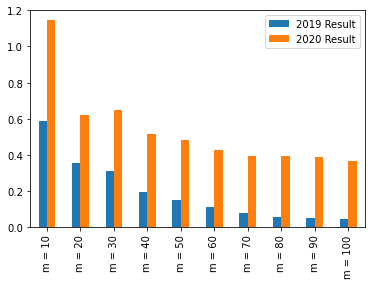

In [217]:
df_compare.plot(kind = 'bar')

# Part 3, Recommendation

In [218]:
i = 0
c = 0
q = []
p = []
while i < len(all_weights[5]):
    if all_weights[5][i] > 0:
        q.append(c)
        p.append(all_weights[5][i])
        c += 1
        i += 1
    else:
        c += 1
        i += 1

In [219]:
resultmm = pd.DataFrame()
resultmm['Stock'] = [column_names[i] for i in q]
resultmm['Weights'] = p
resultmm.index = q

In [220]:
print(list(resultmm['Stock']))

['ATVI', 'ADBE', 'AMD', 'ALGN', 'GOOG', 'AMZN', 'AMGN', 'ADI', 'AAPL', 'ASML', 'ADSK', 'ADP', 'BIDU', 'BIIB', 'BMRN', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CERN', 'CHTR', 'CHKP', 'CTAS', 'CSCO', 'CTXS', 'CTSH', 'CMCSA', 'CPRT', 'COST', 'CSX', 'DLTR', 'EBAY', 'EXC', 'FB', 'GILD', 'ILMN', 'INTC', 'INTU', 'ISRG', 'JD', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MSFT', 'NFLX', 'SIRI', 'TSLA', 'VRSN', 'VRTX', 'WBA', 'WDC', 'XLNX']


In [221]:
resultmm1 = resultmm.sort_values(by='Weights', ascending=False)[:10].copy()
resultmm1

,Stock,Weights
11,AAPL,0.104427
63,MSFT,0.101294
7,AMZN,0.099969
6,GOOG,0.086230
41,FB,0.040442
48,INTC,0.039921
15,ADP,0.034383
32,COST,0.034271
27,CSCO,0.029094
30,CMCSA,0.025142


<AxesSubplot:xlabel='Stock'>

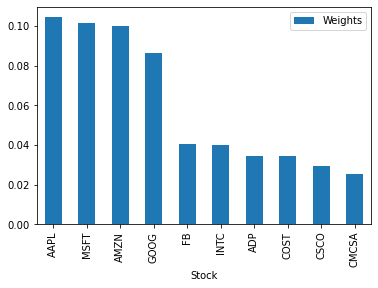

In [222]:
resultmm1.index = resultmm1['Stock']
resultmm1.plot(kind = 'bar')

# Note: The result for 11 hours code running are written in the report. 